<a href="https://colab.research.google.com/github/NallelyPintor/Keras-CNN-Dog-or-Cat-Classification/blob/main/Keras_CNN_Dog_or_Cat_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls

sample_data  test.zip  train.zip


In [2]:
!unzip train.zip

Archive:  train.zip
  inflating: train/cat.0.jpg         
  inflating: train/cat.1.jpg         
  inflating: train/cat.10.jpg        
  inflating: train/cat.100.jpg       
  inflating: train/cat.1000.jpg      
  inflating: train/cat.101.jpg       
  inflating: train/cat.102.jpg       
  inflating: train/cat.103.jpg       
  inflating: train/cat.104.jpg       
  inflating: train/cat.105.jpg       
  inflating: train/cat.106.jpg       
  inflating: train/cat.107.jpg       
  inflating: train/cat.108.jpg       
  inflating: train/cat.109.jpg       
  inflating: train/cat.11.jpg        
  inflating: train/cat.110.jpg       
  inflating: train/cat.111.jpg       
  inflating: train/cat.112.jpg       
  inflating: train/cat.113.jpg       
  inflating: train/cat.114.jpg       
  inflating: train/cat.115.jpg       
  inflating: train/cat.116.jpg       
  inflating: train/cat.117.jpg       
  inflating: train/cat.118.jpg       
  inflating: train/cat.119.jpg       
  inflating: train/cat.12.jpg 

In [39]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
#from keras.utils import to_categorical
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

Define constants

In [40]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

Prepare training data

In [41]:
#filenames = os.listdir("../input/train/train")
filenames = os.listdir('/content/train')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [42]:
df.head()

filename  category
0  dog.264.jpg         1
1  dog.306.jpg         1
2  dog.429.jpg         1
3  cat.442.jpg         0
4  dog.342.jpg         1

See Total In count

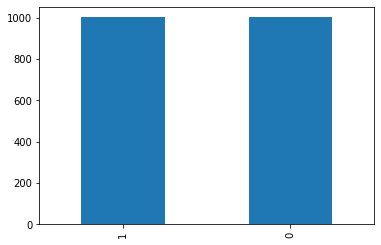

In [43]:
df['category'].value_counts().plot.bar()

See sample image

In [44]:
from matplotlib.image import imread

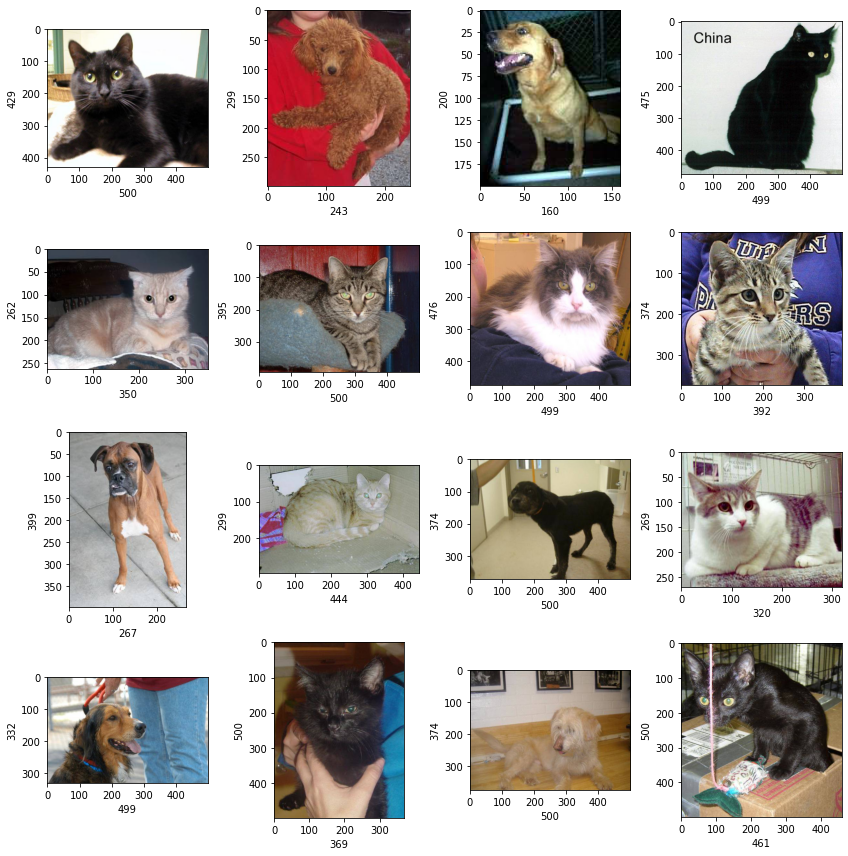

In [45]:
#Visualización del tamaño de las imagenes 
plt.figure(figsize=(12,12)) 
path = '/content/train' 
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))

    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10) #width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10) #height of image

## Build Model

In [62]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_7 (Batc  (None, 61, 61, 64)      

Callbacks

In [63]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

Early Stop

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [64]:
earlystop = EarlyStopping(patience=10)

Learning Rate Reduction

We will reduce the learning rate when then accuracy not increase for 2 steps

In [65]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [66]:
callbacks = [earlystop, learning_rate_reduction]

## Prepare data

Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [67]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [68]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

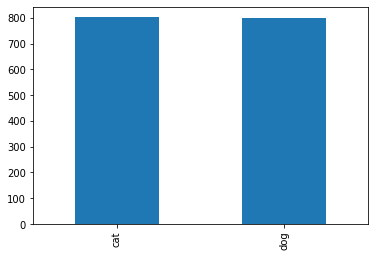

In [69]:
train_df['category'].value_counts().plot.bar()

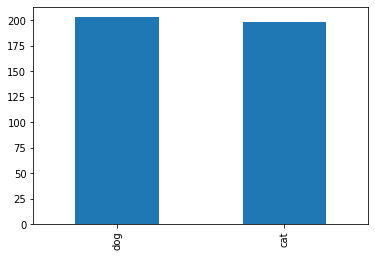

In [70]:
validate_df['category'].value_counts().plot.bar()

In [71]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## Traning Generator

In [72]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    '/content/train', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1601 validated image filenames belonging to 2 classes.


In [73]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    '/content/train', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 401 validated image filenames belonging to 2 classes.


## See how our generator work

In [74]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    '/content/train', 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


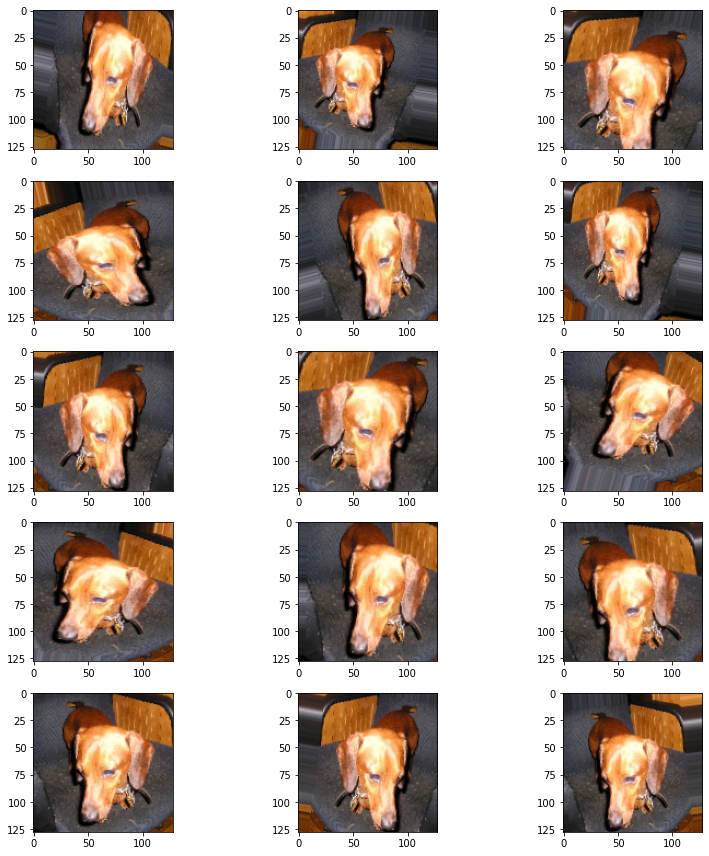

In [75]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Fit Model

In [76]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


106/106 [==============================] - 97s 901ms/step - loss: 1.3784 - accuracy: 0.5523 - val_loss: 1.2900 - val_accuracy: 0.4821 - lr: 0.0010
Epoch 2/50
106/106 [==============================] - 101s 949ms/step - loss: 0.9903 - accuracy: 0.5744 - val_loss: 0.8561 - val_accuracy: 0.5205 - lr: 0.0010
Epoch 3/50
106/106 [==============================] - 94s 891ms/step - loss: 0.8229 - accuracy: 0.5883 - val_loss: 0.8879 - val_accuracy: 0.5359 - lr: 0.0010
Epoch 4/50
106/106 [==============================] - 95s 896ms/step - loss: 0.7579 - accuracy: 0.6154 - val_loss: 0.9581 - val_accuracy: 0.5692 - lr: 0.0010
Epoch 5/50
106/106 [==============================] - 94s 886ms/step - loss: 0.6904 - accuracy: 0.6501 - val_loss: 0.6351 - val_accuracy: 0.6436 - lr: 0.0010
Epoch 6/50
106/106 [==============================] - 94s 885ms/step - loss: 0.6431 - accuracy: 0.6538 - val_loss: 0.6901 - val_accuracy: 0.6487 - lr: 0.0010
Epoch 7/50
106/106 [==============================] - 93s 873m

## Virtualize Training

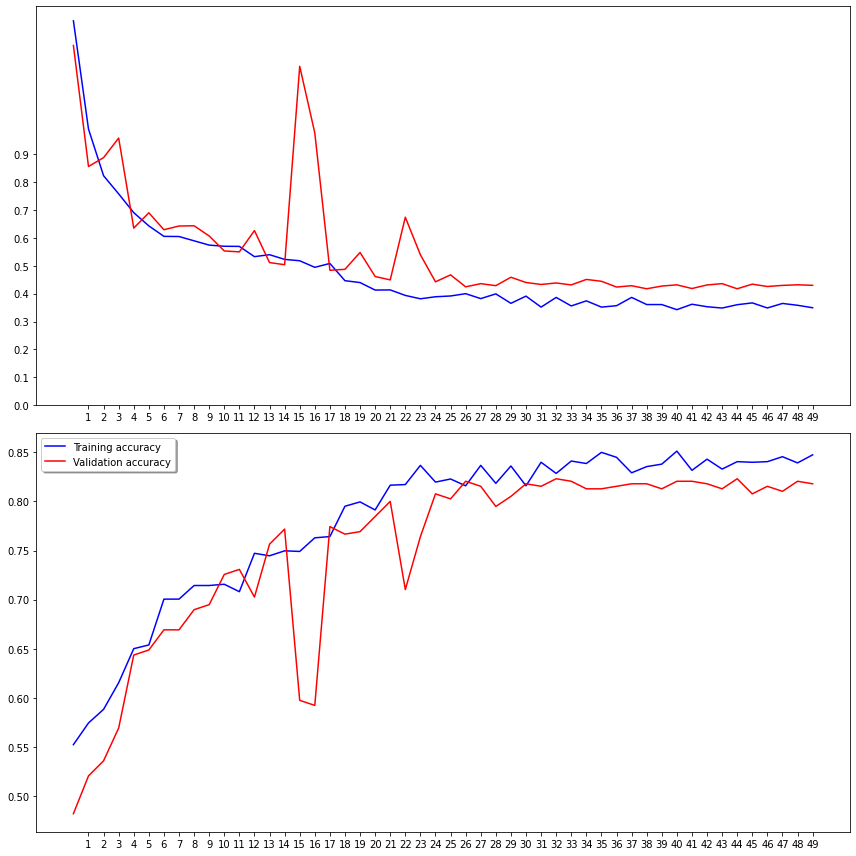

In [77]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
#ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))


legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

##Prepare Testing Data

In [28]:
!unzip test.zip

Archive:  test.zip
  inflating: test/1.jpg              
  inflating: test/10.jpg             
  inflating: test/100.jpg            
  inflating: test/1000.jpg           
  inflating: test/101.jpg            
  inflating: test/102.jpg            
  inflating: test/103.jpg            
  inflating: test/104.jpg            
  inflating: test/105.jpg            
  inflating: test/106.jpg            
  inflating: test/107.jpg            
  inflating: test/108.jpg            
  inflating: test/109.jpg            
  inflating: test/11.jpg             
  inflating: test/110.jpg            
  inflating: test/111.jpg            
  inflating: test/112.jpg            
  inflating: test/113.jpg            
  inflating: test/114.jpg            
  inflating: test/115.jpg            
  inflating: test/116.jpg            
  inflating: test/117.jpg            
  inflating: test/118.jpg            
  inflating: test/119.jpg            
  inflating: test/12.jpg             
  inflating: test/120.jpg      

In [78]:
test_filenames = os.listdir('/content/test')
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## Create Testing Generator

In [79]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    '/content/test', 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 1000 validated image filenames.


## Predict

In [80]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [81]:
test_df['category'] = np.argmax(predict, axis=-1)

In [82]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [83]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

Virtaulize Result

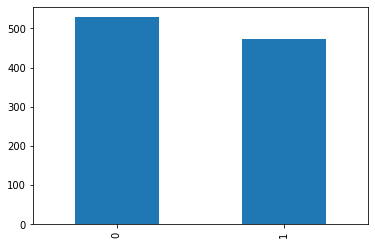

In [84]:
test_df['category'].value_counts().plot.bar()

## See predicted result with images

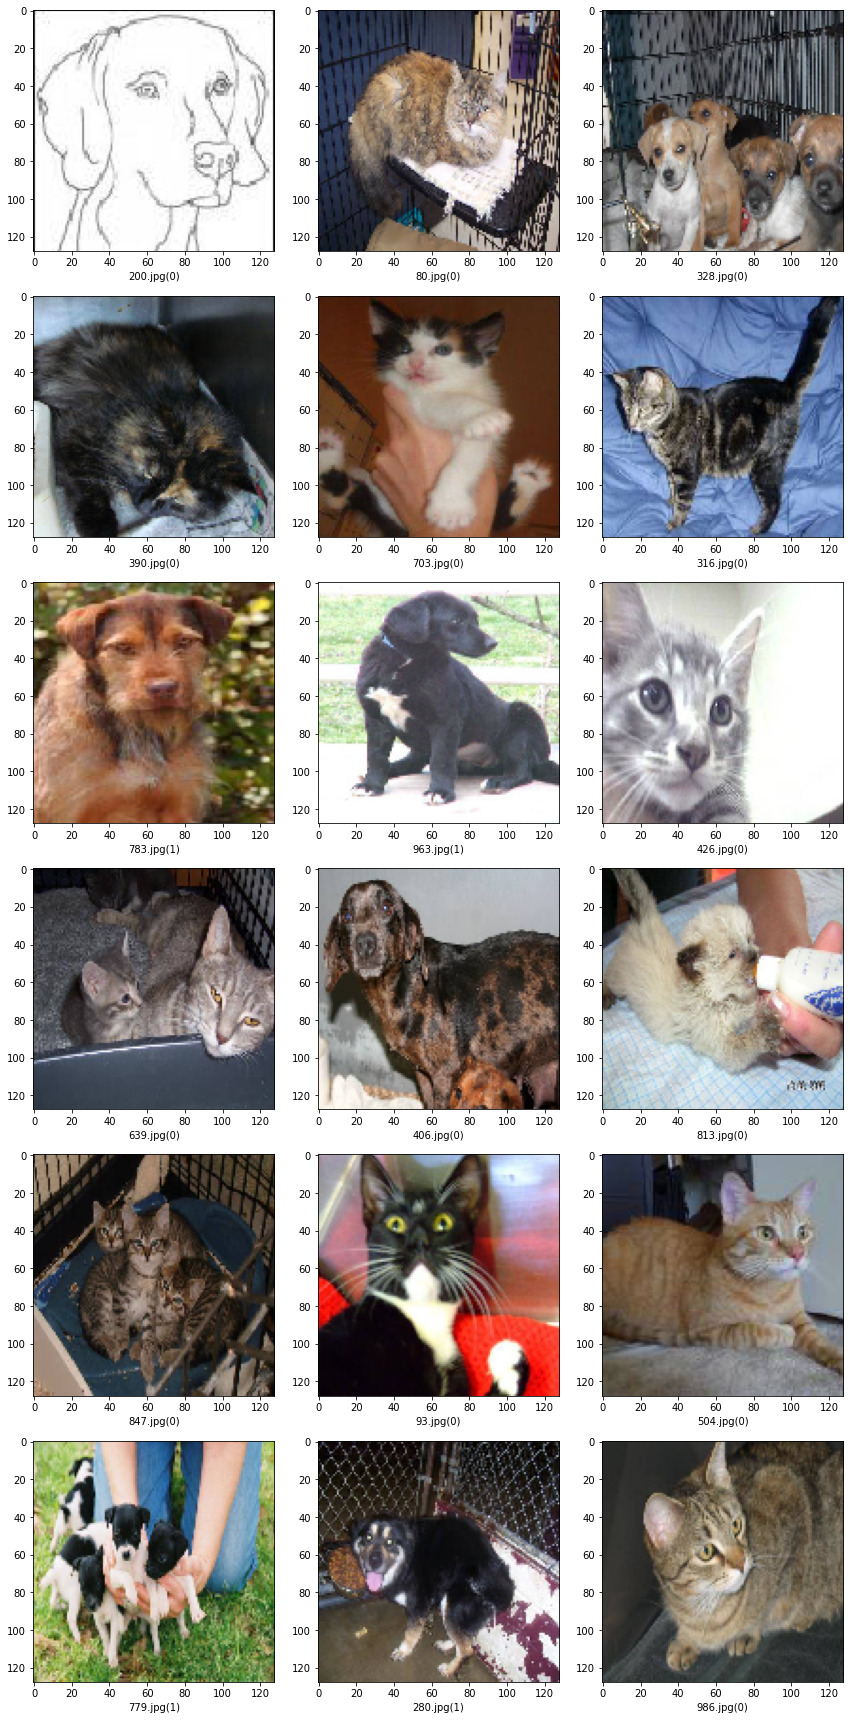

In [87]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img('/content/test'+ '/' + filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()
#dog 1 , cat 0